# Sections

- <a href="#1.-Preprocessing"> Preprocessing </a><br>
    - <a href="#Basic-EDA"> Basic Exploratory Data Analysis</a><br>
    - <a href="#SMOTE"> SMOTE (Oversampling) </a><br>
    - <a href="#Data-Wrangling"> Data Wrangling</a><br>
- <a href="#Modeling"> Modeling</a><br>
    - <a href="#KNN-Classifier"> K-Nearest-Neighbors Classifier</a><br>
    - <a href="#Random-Forest"> Random Forest Classifier</a><br> 
- <a href="#Figures-for-Presentation"> Misc: Figures for Presentation</a><br>

# Preprocessing

In [1]:
# installing data wrangling + plotting modules
import numpy as np
import pandas as pd

%matplotlib inline 
from matplotlib import pyplot as plt 
import seaborn as sns

wine = pd.read_csv('winequality-red.csv') # load dataset

# transform the ordinal-scaled quality variable (1-10, 10 being highest quality)
# target will become:
    # rating >= 7   ---> 'yes'
    # rating < 7    ---> 'no'

wine['quality'] = ['yes' if row >= 7 else 'no' for row in wine['quality']]

## Basic EDA

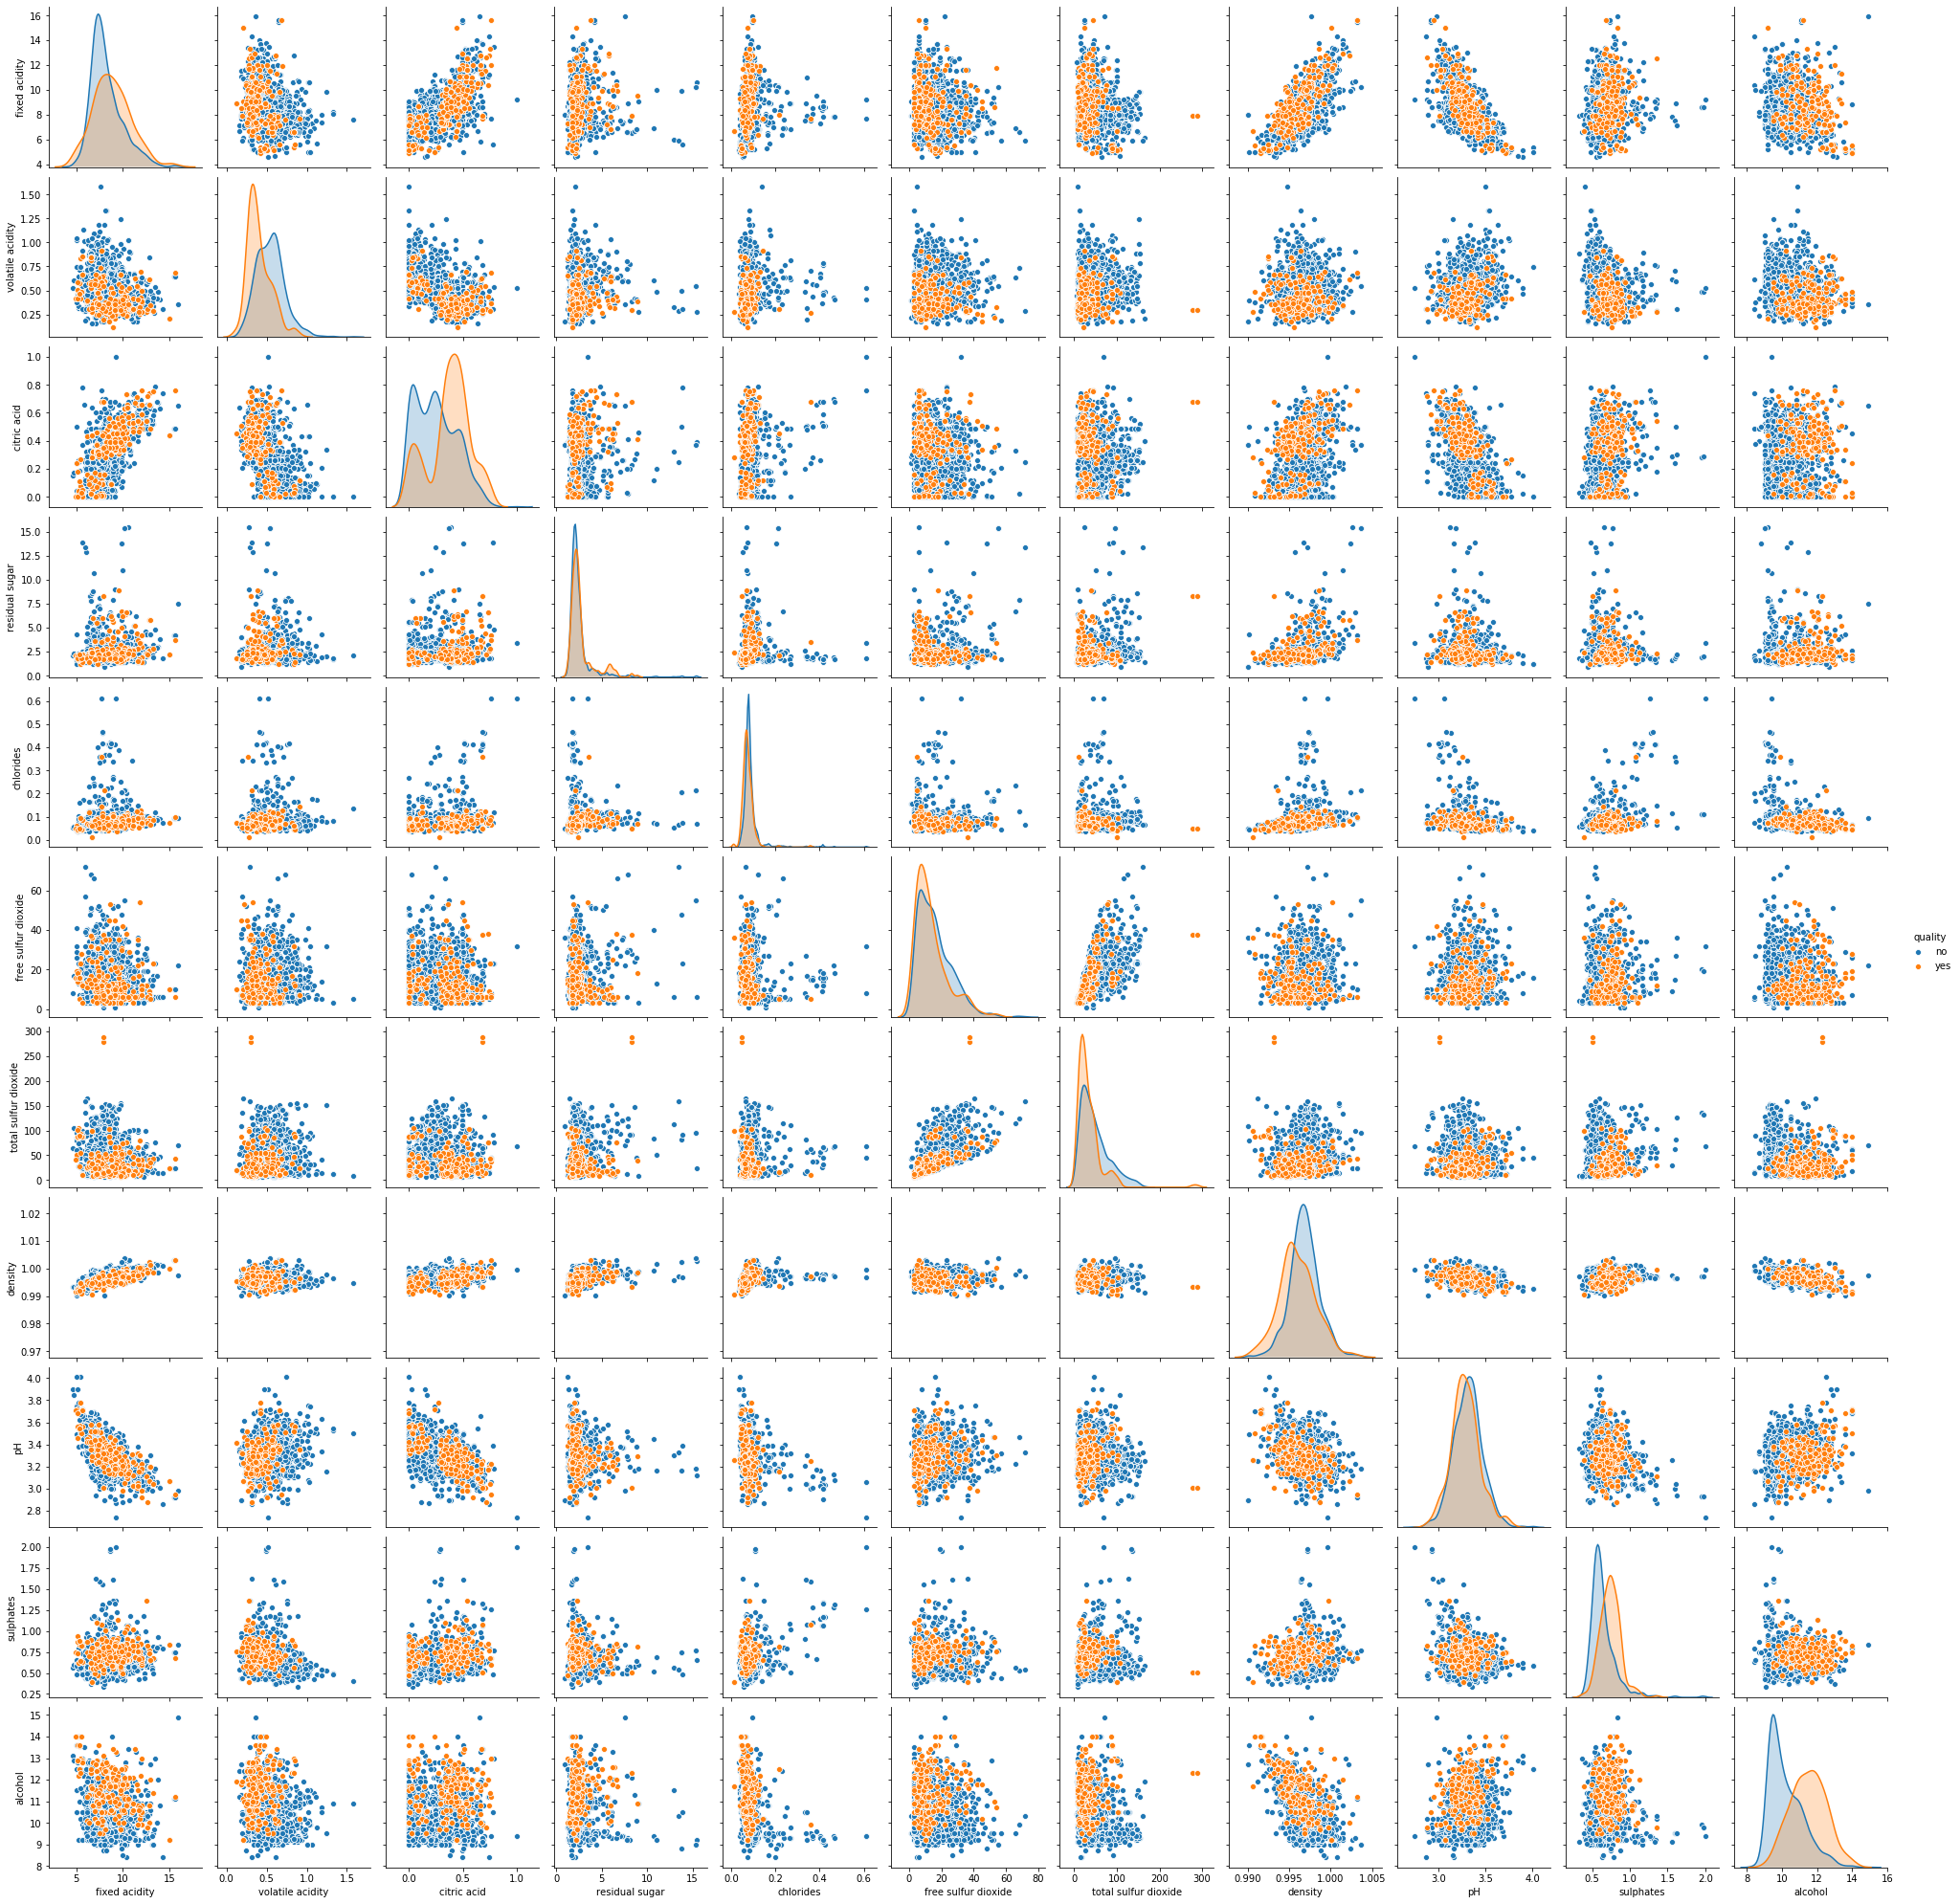

In [2]:
sns.pairplot(wine,hue="quality")

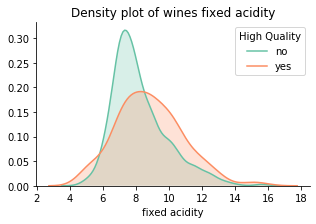

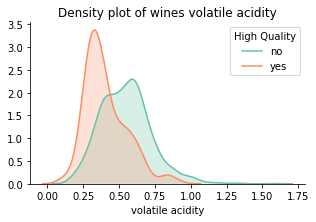

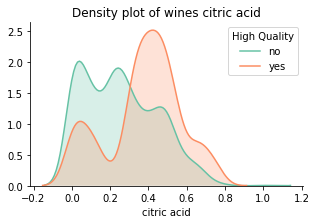

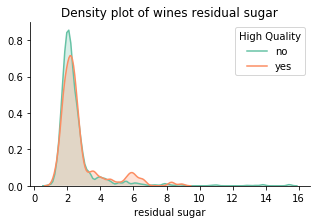

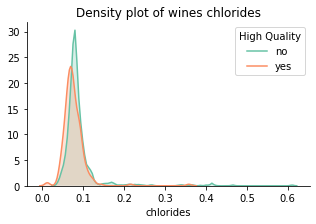

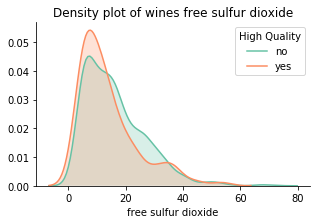

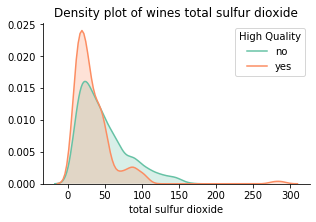

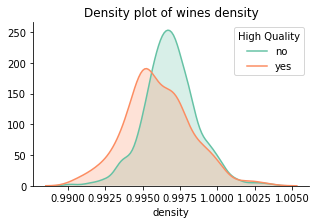

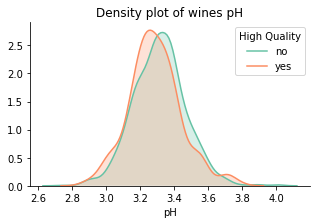

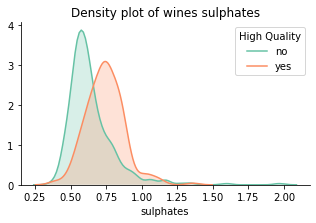

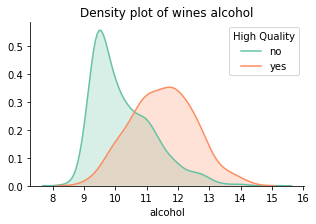

In [308]:
def make_distplot(df,colname,ratio=1):
    fct = sns.FacetGrid(df, hue = 'quality',aspect=ratio,palette="Set2")
    return fct.map(sns.distplot, colname, hist=False, kde=True,kde_kws = {'shade': True, 'linewidth': 1.5})

for column in wine.columns[0:11]:
    make_distplot(wine,column,ratio=1.5)
    plt.legend(title="High Quality")
    plt.title(f'Density plot of wines {column}')

## SMOTE

- The proportion of high-quality vs normal-quality wines is highly imbalanced. I use the oversampling technique SMOTE to create a *training* dataset that is resampled to have an equal proportion of both classes.
- Any variable transformation / standardization will take place after the training/testing set split to ensure data leakage does not occur.

In [4]:
# check for imbalanced classes
print(wine.quality.value_counts(),'\n')

print(f'Proportion of high-quality wines: {round(wine.quality.value_counts()["yes"]/wine.quality.count()*100,2)}%')
print(f'Proportion of normal-quality wines: {round(wine.quality.value_counts()["no"]/wine.quality.count()*100,2)}%')
# the classes are highly imbalanced!

# split data into training and test sets; random state for reproducability
from sklearn.model_selection import train_test_split

features = wine.drop('quality',axis=1)
target = wine['quality']
Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, 
                                                random_state=42, 
                                                stratify=target)

no     1382
yes     217
Name: quality, dtype: int64 

Proportion of high-quality wines: 13.57%
Proportion of normal-quality wines: 86.43%


In [376]:
# use SMOTE to re-sample equally
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(Xtrain,ytrain) # res = resampled

print(y_res.value_counts())
# now the classes are equally represented

yes    1036
no     1036
Name: quality, dtype: int64


## Data Wrangling

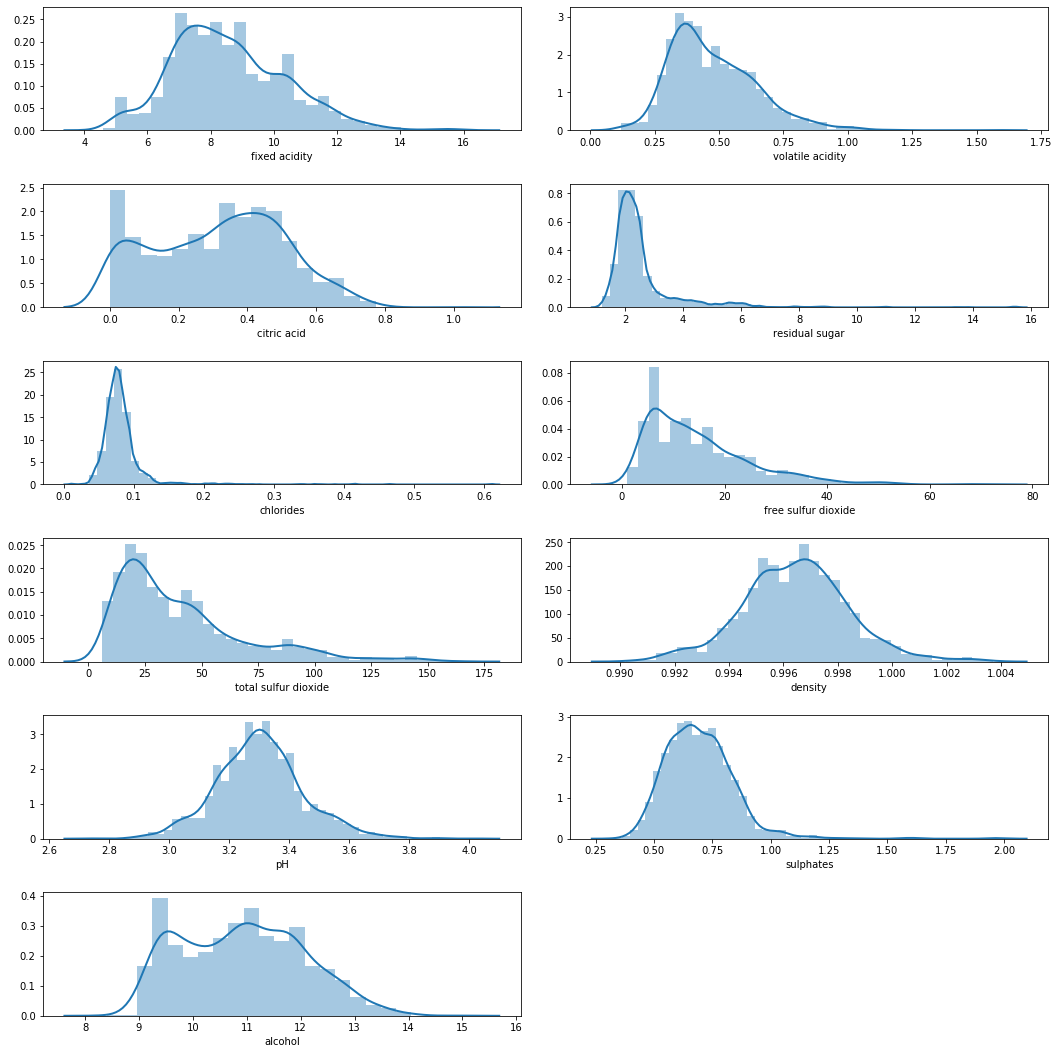

In [6]:
# check distributions to see which ones to transform
fig = plt.figure(figsize=(15,15))
for index,column in enumerate(list(X_res.columns)):
    plt.subplot(6,2,index+1)
    sns.distplot(X_res.loc[:, column], kde_kws={"lw":2})
#     sns.distplot(X_res.loc[:, column], hist_kws={"color":"r"}, kde_kws={"color":"b", "lw":2})
fig.tight_layout(pad = 2)

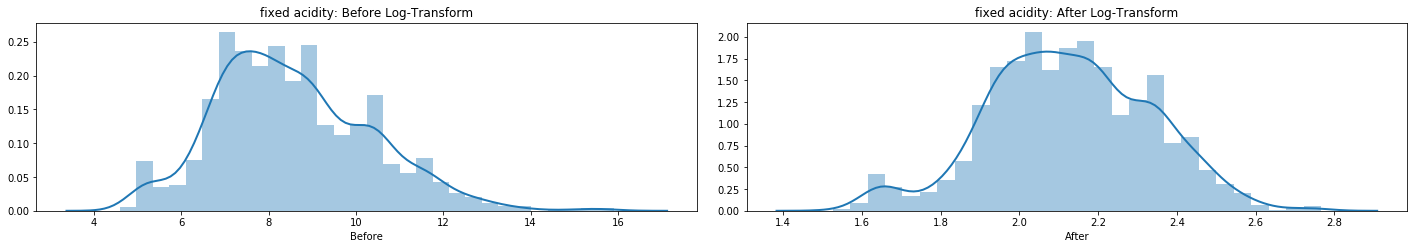

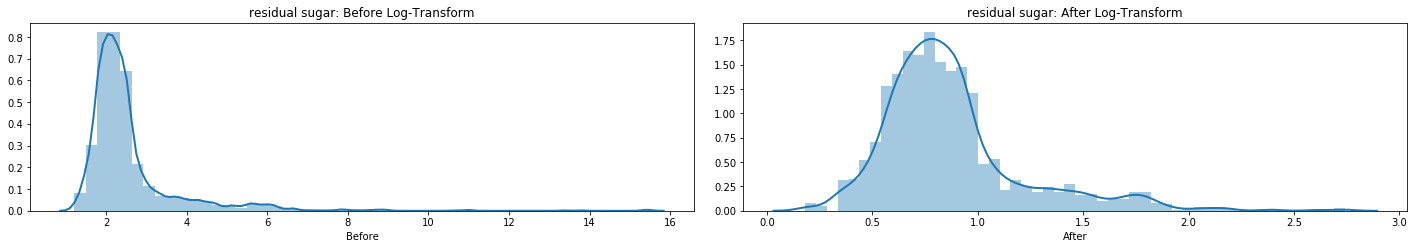

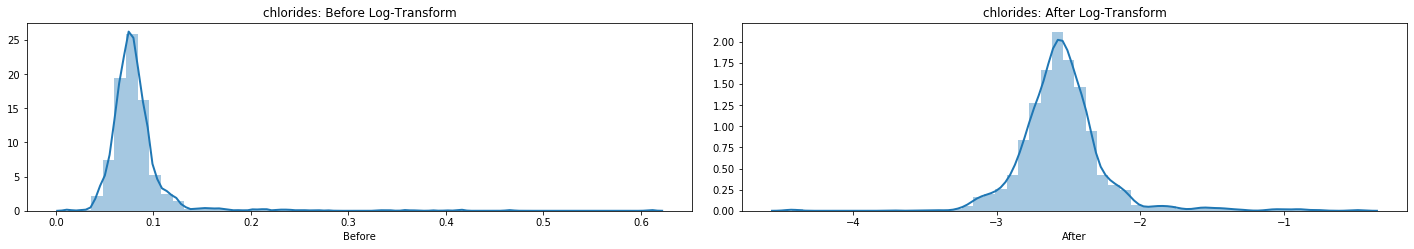

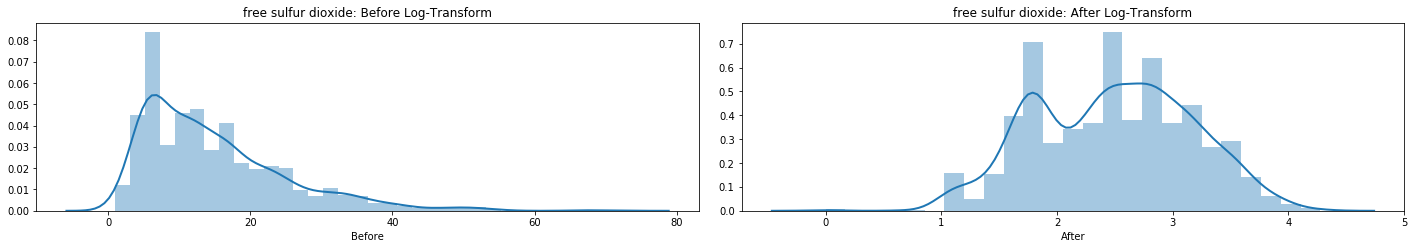

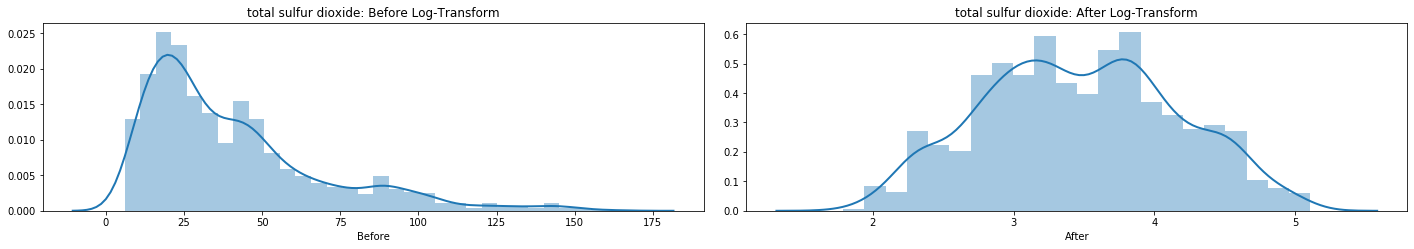

In [7]:
# Plotting function to visualize log transform
def log_transform_col(data,column_name):
    df = pd.DataFrame({'Before':data[column_name],
                      'After':np.log(data[column_name])})
    
    fig = plt.figure(figsize=(20,20))
    for index,column in enumerate(list(df.columns)):
        plt.subplot(6,2,index+1)
        plt.title(f'{column_name}: {column} Log-Transform')
        sns.distplot(df.loc[:, column], kde_kws={"lw":2})
        fig.tight_layout(pad = 2)
        
log_transform_col(X_res,'fixed acidity')
log_transform_col(X_res,'residual sugar')
log_transform_col(X_res,'chlorides')
log_transform_col(X_res,'free sulfur dioxide')
log_transform_col(X_res,'total sulfur dioxide')

In [9]:
def TransformVariables(train_X, test_X):
    df_train, df_test = train_X.copy(), test_X.copy()
    columns = ['fixed acidity','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide']
    for col in columns:
        df_train[col] = np.log(df_train[col])
        df_test[col] = np.log(df_test[col])
    
    return(df_train,df_test)

X_res, Xtest = TransformVariables(X_res, Xtest)

In [15]:
wine_temp = pd.concat((X_res,y_res),axis=1)

In [24]:
X_res

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          2.104134          0.635000     0.100000        0.741937  -2.617296   
1          1.902108          0.320000     0.440000        0.875469  -2.796881   
2          2.341806          0.440000     0.420000        0.405465  -1.931022   
3          2.079442          0.450000     0.230000        0.788457  -2.364460   
4          2.476538          0.380000     0.510000        0.693147  -2.111965   
...             ...               ...          ...             ...        ...   
2067       2.021473          0.420759     0.332472        0.756675  -2.853627   
2068       2.140220          0.416681     0.189345        0.916291  -2.478759   
2069       2.406945          0.310000     0.530000        0.788457  -2.813411   
2070       2.308602          0.475456     0.596035        0.793707  -2.346591   
2071       2.085290          0.585829     0.166431        0.595481  -2.732032   

      free sulfur dioxide  total sulfur dioxide   density        pH  \
0                3.218876              4.094345  0.996380  3.290000   
1                3.178054              3.526361  0.994840  3.290000   
2                3.526361              3.871201  0.998320  3.380000   
3                2.772589              3.367296  0.996200  3.210000   
4                1.945910              2.995732  0.999600  3.240000   
...                   ...                   ...       ...       ...   
2067             3.473430              3.983193  0.996569  3.290646   
2068             2.912920              3.875468  0.996940  3.363843   
2069             1.098612              2.302585  0.995720  3.020000   
2070             1.842775              2.728770  0.996458  3.127684   
2071             1.110132              2.772589  0.996217  3.415307   

      sulphates    alcohol  
0      0.750000  10.900000  
1      0.800000  11.600000  
2      0.860000   9.900000  
3      0.490000  10.200000  
4      0.760000  10.400000  
...         ...        ...  
2067   0.762245  10.748301  
2068   0.828210  10.878165  
2069   0.830000  10.900000  
2070   0.669421  12.019823  
2071   0.915307  10.508690  

[2072 rows x 11 columns]

# Modeling

In [17]:
# load in all packages
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [414]:
def EvaluateModel(model, train_X, test_X, train_y, test_y):
    model.fit(train_X,train_y)
    print(model)
    print(f'Train set accuracy: {round(model.score(train_X,train_y)*100,2)}%')
    print(f'Test set accuracy: {round(model.score(test_X,test_y)*100,2)}%')
    print('Confusion Matrix:','\n', confusion_matrix(test_y, model.predict(test_X)))
    print('Classification Report:','\n', classification_report(test_y, model.predict(test_X)))

In [63]:
def TransformTarget(train_y,test_y):
    train = train_y.copy()
    test = test_y.copy()
    train = [1 if row=='yes' else 0 for row in train]
    test = [1 if row=='yes' else 0 for row in test]
    return(train,test)
y_res,ytest = TransformTarget(y_res,ytest)

## KNN Classifier

In [187]:
knn = KNeighborsClassifier(n_neighbors=2)
EvaluateModel(knn,X_res,Xtest,y_res,ytest)

KNeighborsClassifier(n_neighbors=2)
Train set accuracy: 0.9898648648648649%
Test set accuracy: 0.885%
Confusion Matrix: 
 [[316  30]
 [ 16  38]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       346
           1       0.56      0.70      0.62        54

    accuracy                           0.89       400
   macro avg       0.76      0.81      0.78       400
weighted avg       0.90      0.89      0.89       400



In [204]:
# try with scaled data
def ScaleData(train_X,test_X):
    train = train_X.copy()
    test = test_X.copy()
# standardize the data
    for column in train.columns:
        col_mean, col_sd = train[column].mean(), train[column].std()
        train[column] = (train[column] - col_mean) / col_sd
    for column in test.columns:
        col_mean, col_sd = test[column].mean(), test[column].std()
        test[column] = (test[column] - col_mean) / col_sd
    return(train,test)

In [205]:
scaled_Xtrain, scaled_Xtest = ScaleData(X_res,Xtest)

In [206]:
scaled_ytrain, scaled_ytest = y_res.copy(), ytest.copy()

In [236]:
knn = KNeighborsClassifier()
EvaluateModel(knn,scaled_Xtrain, scaled_Xtest,scaled_ytrain, scaled_ytest)

KNeighborsClassifier()
Train set accuracy: 0.9232625482625483%
Test set accuracy: 0.7%
Confusion Matrix: 
 [[232 114]
 [  6  48]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.67      0.79       346
           1       0.30      0.89      0.44        54

    accuracy                           0.70       400
   macro avg       0.64      0.78      0.62       400
weighted avg       0.88      0.70      0.75       400



In [240]:
knn = KNeighborsClassifier(weights='distance',n_neighbors=10)
EvaluateModel(knn,scaled_Xtrain, scaled_Xtest,scaled_ytrain, scaled_ytest)

KNeighborsClassifier(n_neighbors=10, weights='distance')
Train set accuracy: 1.0%
Test set accuracy: 0.705%
Confusion Matrix: 
 [[232 114]
 [  4  50]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.67      0.80       346
           1       0.30      0.93      0.46        54

    accuracy                           0.70       400
   macro avg       0.64      0.80      0.63       400
weighted avg       0.89      0.70      0.75       400



In [403]:

neighbors = range(1,16)
acc_test= []
acc_train= []

for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n,p=1)
    knn.fit(X_res,y_res)
    acc_train.append(knn.score(X_res,y_res))
    acc_test.append(knn.score(Xtest,ytest))

In [427]:
knn.set_params(n_neighbors=6,p=1)
EvaluateModel(knn,X_res,Xtest,y_res,ytest)

KNeighborsClassifier(n_neighbors=6, p=1)
Train set accuracy: 92.66%
Test set accuracy: 86.75%
Confusion Matrix: 
 [[330  16]
 [ 37  17]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       346
           1       0.52      0.31      0.39        54

    accuracy                           0.87       400
   macro avg       0.71      0.63      0.66       400
weighted avg       0.85      0.87      0.85       400



Text(0.5, 1.0, 'KNN Model Accuracy for (k = 1 - 15)')

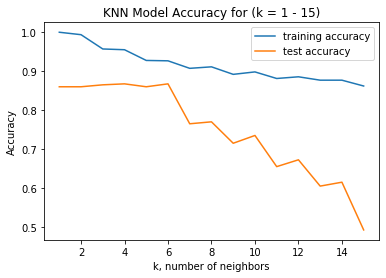

In [407]:
plt.plot(neighbors,acc_train,label='training accuracy')
plt.plot(neighbors,acc_test,label='test accuracy')
plt.legend()
plt.xlabel('k, number of neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for (k = 1 - 15)')

In [242]:
probas = [0.4,0.5,0.6,0.7,0.8]
results = pd.DataFrame(knn.predict_proba(scaled_Xtest))
for prob in probas:
    new_pred = [1 if row >= prob else 0 for row in results[1]]
    print(prob)
    print(confusion_matrix(scaled_ytest,new_pred))
    print(classification_report(scaled_ytest,new_pred))

0.4
[[212 134]
 [  2  52]]
              precision    recall  f1-score   support

           0       0.99      0.61      0.76       346
           1       0.28      0.96      0.43        54

    accuracy                           0.66       400
   macro avg       0.64      0.79      0.60       400
weighted avg       0.89      0.66      0.71       400

0.5
[[232 114]
 [  4  50]]
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       346
           1       0.30      0.93      0.46        54

    accuracy                           0.70       400
   macro avg       0.64      0.80      0.63       400
weighted avg       0.89      0.70      0.75       400

0.6
[[254  92]
 [  9  45]]
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       346
           1       0.33      0.83      0.47        54

    accuracy                           0.75       400
   macro avg       0.65      0.78      0.65    

## Random Forest

In [40]:
# out of box random forest
rfc = RandomForestClassifier(random_state=42)
EvaluateModel(rfc,X_res,Xtest,y_res,ytest)

RandomForestClassifier(random_state=42)
Train set accuracy: 1.0%
Test set accuracy: 0.9025%
Confusion Matrix: 
 [[323  23]
 [ 16  38]]
Classification Report: 
               precision    recall  f1-score   support

          no       0.95      0.93      0.94       346
         yes       0.62      0.70      0.66        54

    accuracy                           0.90       400
   macro avg       0.79      0.82      0.80       400
weighted avg       0.91      0.90      0.90       400



In [430]:
# tuned rf
rf = RandomForestClassifier(random_state=42,n_estimators=500,max_features='sqrt',max_depth=5)
EvaluateModel(rf,X_res,Xtest,y_res,ytest)

RandomForestClassifier(max_depth=5, max_features='sqrt', n_estimators=500,
                       random_state=42)
Train set accuracy: 89.58%
Test set accuracy: 81.0%
Confusion Matrix: 
 [[283  63]
 [ 13  41]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.82      0.88       346
           1       0.39      0.76      0.52        54

    accuracy                           0.81       400
   macro avg       0.68      0.79      0.70       400
weighted avg       0.88      0.81      0.83       400



In [99]:
# tuned rf
rf = RandomForestClassifier(random_state=42,n_estimators=500,max_features='sqrt',min_samples_split=10)
EvaluateModel(rf,X_res,Xtest,y_res,ytest)

RandomForestClassifier(max_features='sqrt', min_samples_split=10,
                       n_estimators=500, random_state=42)
Train set accuracy: 0.9908301158301158%
Test set accuracy: 0.9%
Confusion Matrix: 
 [[320  26]
 [ 14  40]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       346
           1       0.61      0.74      0.67        54

    accuracy                           0.90       400
   macro avg       0.78      0.83      0.80       400
weighted avg       0.91      0.90      0.90       400



In [112]:
feat_imps = pd.DataFrame({'importance':rf.feature_importances_,'features':X_res.columns}).sort_values('importance',ascending=False)

Text(0.5, 1.0, 'Relative Importance of Features')

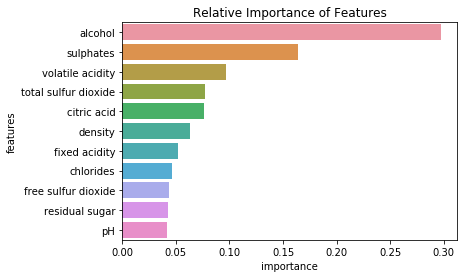

In [118]:
sns.barplot(y="features",x="importance",data=feat_imps)
plt.title('Relative Importance of Features')

In [245]:
# tuned rf
rf = RandomForestClassifier(random_state=42,n_estimators=500,max_features='sqrt',min_samples_split=10)
EvaluateModel(rf,X_res,Xtest,y_res,ytest)

RandomForestClassifier(max_features='sqrt', min_samples_split=10,
                       n_estimators=500, random_state=42)
Train set accuracy: 0.9908301158301158%
Test set accuracy: 0.9%
Confusion Matrix: 
 [[320  26]
 [ 14  40]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       346
           1       0.61      0.74      0.67        54

    accuracy                           0.90       400
   macro avg       0.78      0.83      0.80       400
weighted avg       0.91      0.90      0.90       400



In [255]:
from sklearn.tree import export_text
tree_rules = export_text(rf.estimators_[0], feature_names=list(X_res.columns))

In [257]:
print(tree_rules)

|--- sulphates <= 0.64
|   |--- density <= 1.00
|   |   |--- total sulfur dioxide <= 2.71
|   |   |   |--- chlorides <= -2.33
|   |   |   |   |--- volatile acidity <= 0.70
|   |   |   |   |   |--- sulphates <= 0.54
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- sulphates >  0.54
|   |   |   |   |   |   |--- residual sugar <= 0.82
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- residual sugar >  0.82
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- volatile acidity >  0.70
|   |   |   |   |   |--- class: 0.0
|   |   |   |--- chlorides >  -2.33
|   |   |   |   |--- class: 0.0
|   |   |--- total sulfur dioxide >  2.71
|   |   |   |--- citric acid <= 0.13
|   |   |   |   |--- fixed acidity <= 1.65
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- fixed acidity >  1.65
|   |   |   |   |   |--- free sulfur dioxide <= 3.48
|   |   |   |   |   |   |--- density <= 1.00
|   |   |   |   |   |   |   |--- total sulfur dioxide <= 4.63

In [246]:
probas = [0.4,0.5,0.6,0.7,0.8]
results = pd.DataFrame(rf.predict_proba(Xtest))
for prob in probas:
    new_pred = [1 if row >= prob else 0 for row in results[1]]
    print(prob)
    print(confusion_matrix(ytest,new_pred))
    print(classification_report(ytest,new_pred))

0.4
[[309  37]
 [  9  45]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93       346
           1       0.55      0.83      0.66        54

    accuracy                           0.89       400
   macro avg       0.76      0.86      0.80       400
weighted avg       0.91      0.89      0.89       400

0.5
[[320  26]
 [ 14  40]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       346
           1       0.61      0.74      0.67        54

    accuracy                           0.90       400
   macro avg       0.78      0.83      0.80       400
weighted avg       0.91      0.90      0.90       400

0.6
[[333  13]
 [ 19  35]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       346
           1       0.73      0.65      0.69        54

    accuracy                           0.92       400
   macro avg       0.84      0.81      0.82    

# Figures for Presentation

In [278]:
smote_data = pd.concat((X_res,pd.Series(['yes' if row == 1 else 'no' for row in y_res],name='quality')),axis=1)

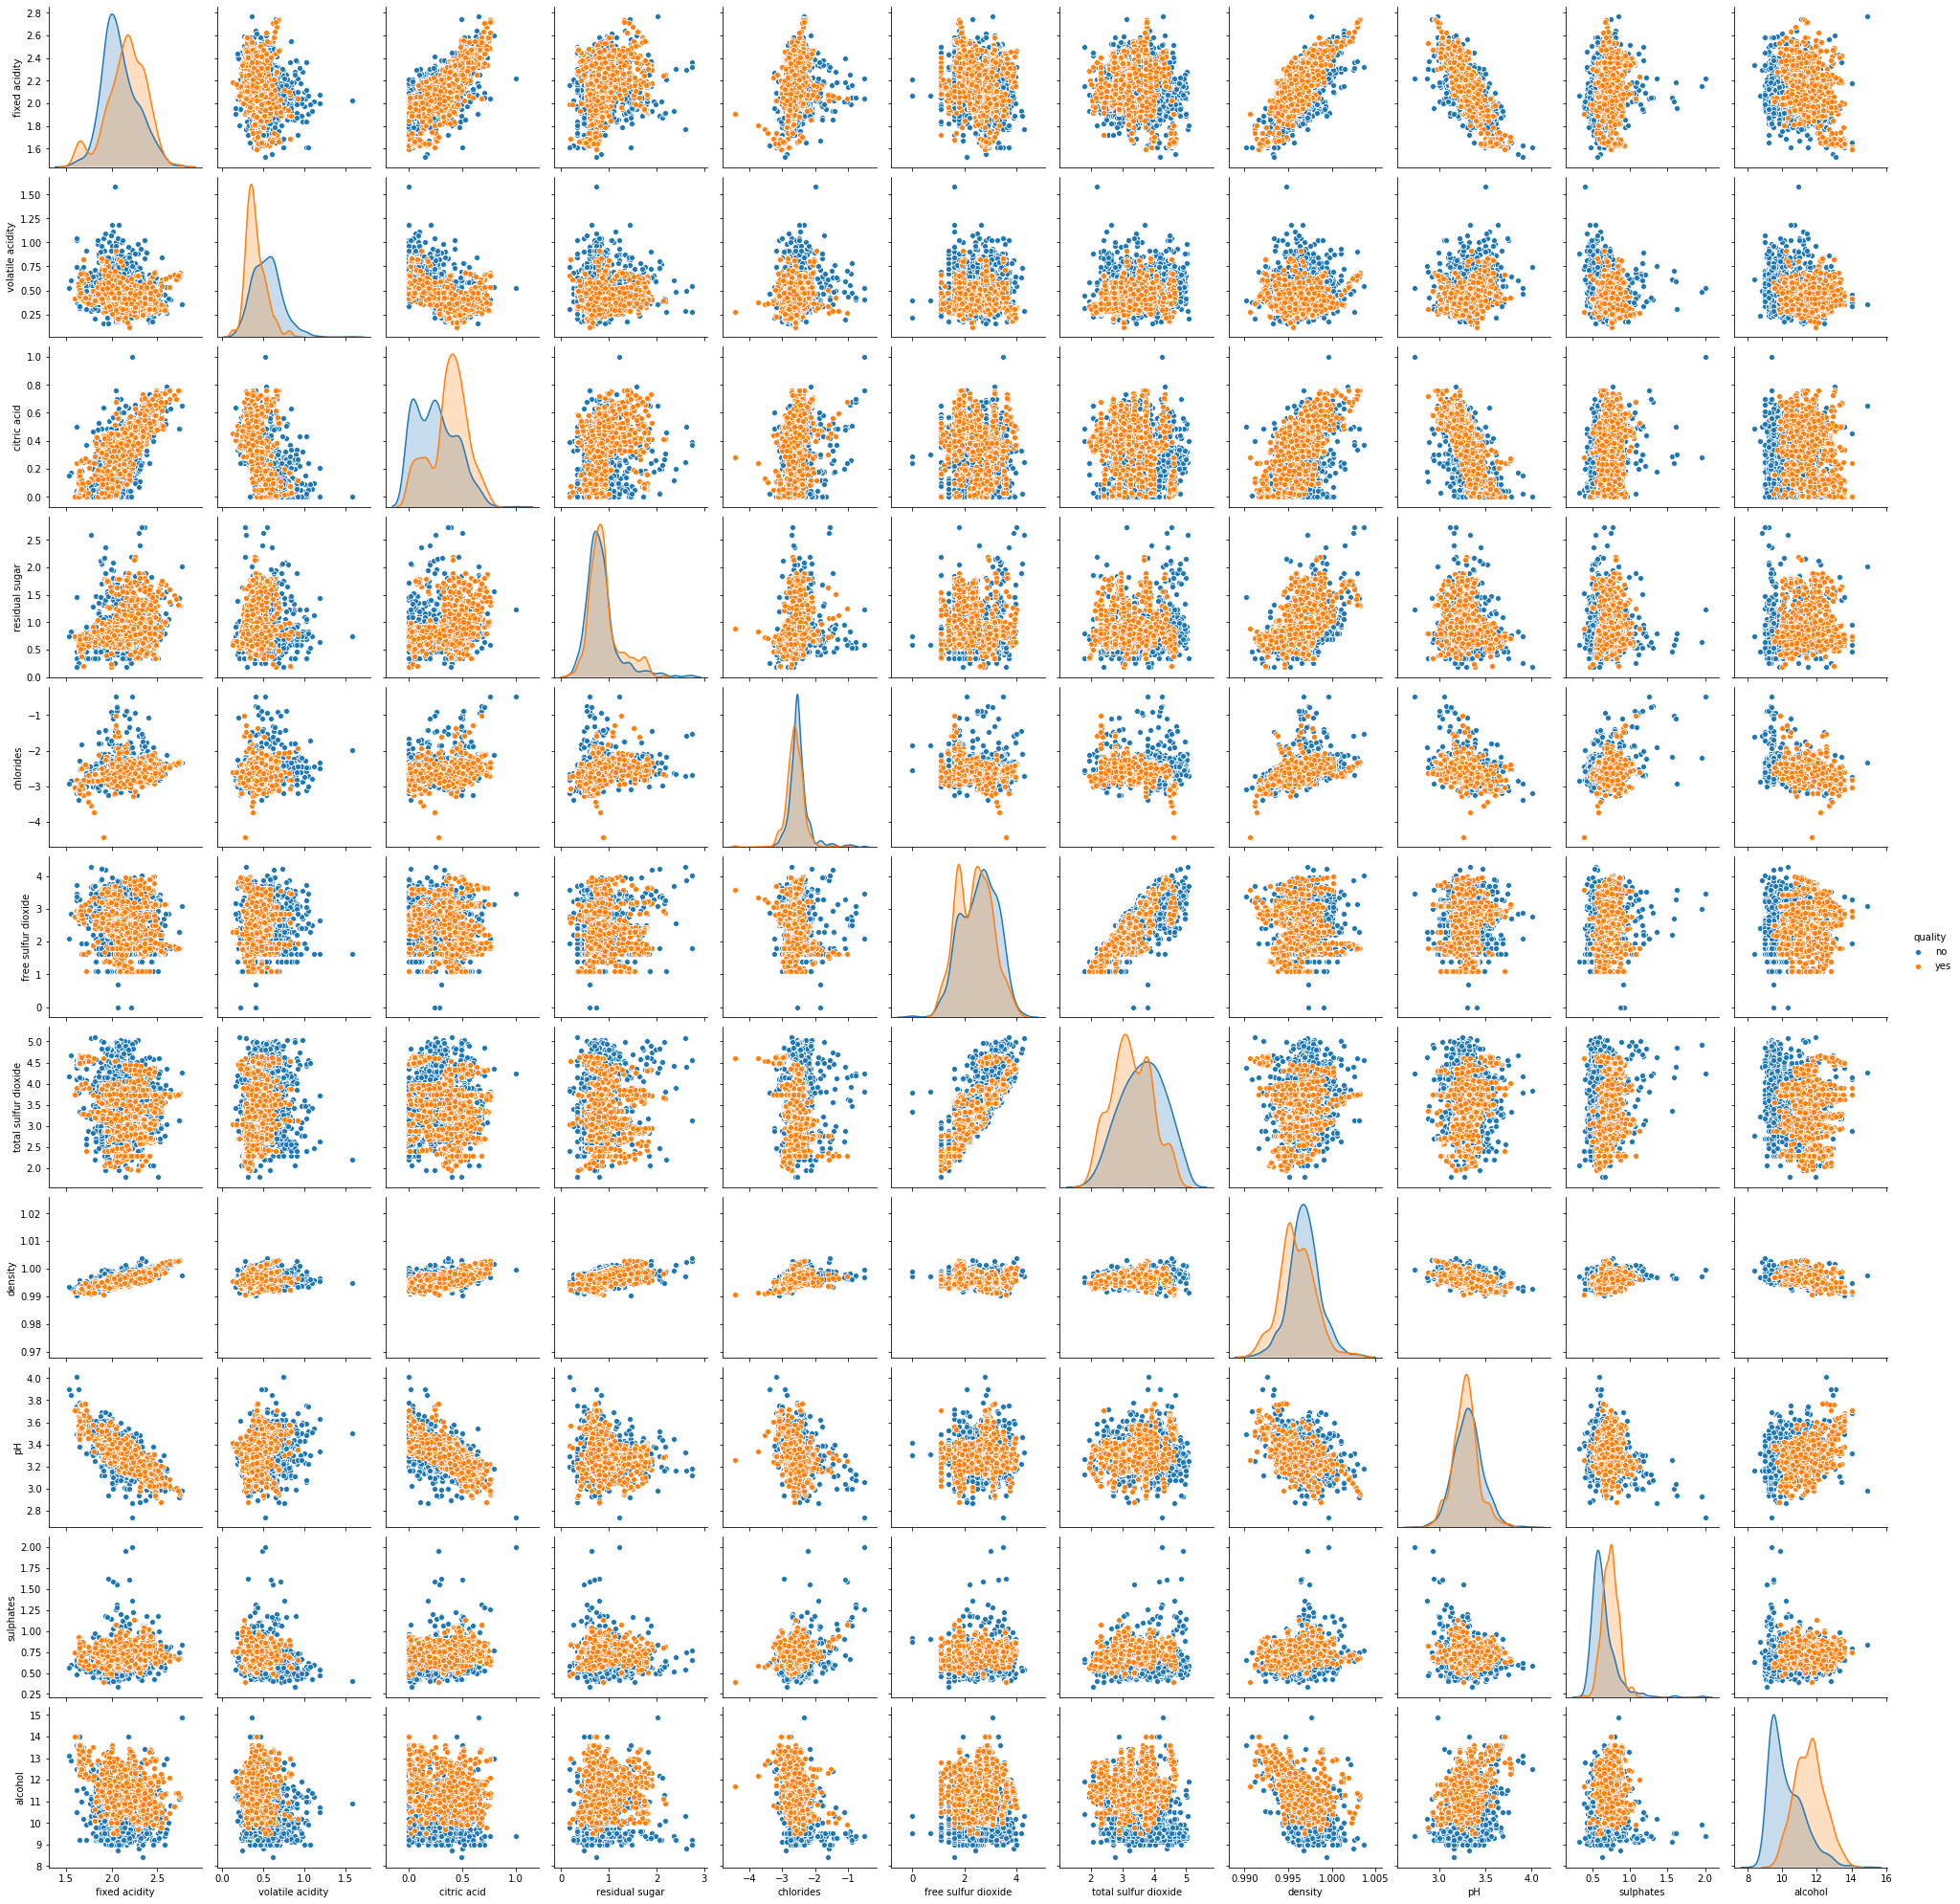

In [281]:
sns.pairplot(smote_data,hue='quality')

Text(0.5, 1.0, 'Scatterplot of Wine alcohol content vs. free sulfur dioxide')

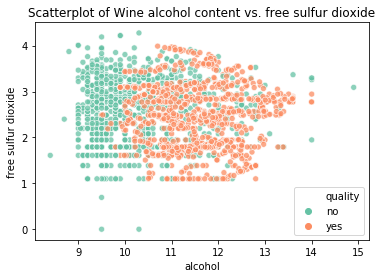

In [304]:
sns.scatterplot(x="alcohol",y="free sulfur dioxide",hue="quality",data=smote_data,alpha=0.75,palette='Set2')
plt.legend(loc=4)
plt.title('Scatterplot of Wine alcohol content vs. free sulfur dioxide')